# Multi-label Text Classification with Keras

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
toxic_comments = pd.read_csv("/content/drive/My Drive/toxic/toxic_comments.csv")

In [0]:
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Let's remove all the records where any row contain a null value or empty string.

In [0]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [0]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [0]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [0]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


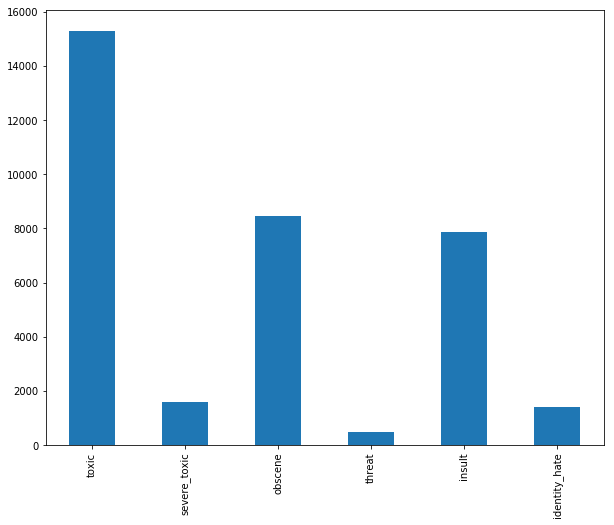

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

# Creating Multi-label Text Classification Models
There are two ways to create multi-label classification models: Using single dense output layer and using multiple dense output layers.

In the first approach, we can use a single dense layer with six outputs with a sigmoid activation functions and binary cross entropy loss functions. Each neuron in the output dense layer will represent one of the six output labels. The sigmoid activation function will return a value between 0 and 1 for each neuron. If any neuron's output value is greater than 0.5, it is assumed that the comment belongs to the class represented by that particular neuron.

In the second approach we will create one dense output layer for each label. We will have a total of 6 dense layers in the output. Each layer will have its own sigmoid function.

# Multi-lable Text Classification Model with Single Output Layer
In this section, we will create multi-label text classification model with single output layer. As always, the first step in the text classification model is to create a function responsible for cleaning the text.

In [0]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In the next step we will create our input and output set. The input is the comment from the comment_text column. We will clean all the comments and will store them in the X variable. The labels or outputs have already been stored in the toxic_comments_labels dataframe. We will use that dataframe values to store output in the y variable. Look at the following script:

In [0]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [0]:
y[168]

array([1, 0, 0, 0, 1, 0])

Here we do not need to perform any one-hot encoding because our output labels are already in the form of one-hot encoded vectors.

In the next step, we will divide our data into training and test sets:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
!unzip '/content/drive/My Drive/toxic/glove6b100dtxt.zip' '/content/drive/My Drive/toxic/glove.6B.100d.txt'

Archive:  /content/drive/My Drive/toxic/glove6b100dtxt.zip
caution: filename not matched:  /content/drive/My Drive/toxic/glove.6B.100d.txt


We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/toxic/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

The following script creates the model. Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 6 neurons since we have 6 labels in the output.

In [0]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


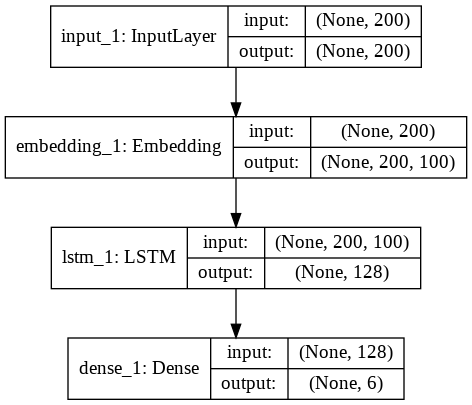

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

From the figure above, you can see that the output layer only contains 1 dense layer with 6 neurons. Let's now train our model:

In [0]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)



Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 513s 5ms/step - loss: 0.1353 - acc: 0.9647 - val_loss: 0.0770 - val_acc: 0.9754
Epoch 2/5
102124/102124 [==============================] - 510s 5ms/step - loss: 0.0642 - acc: 0.9784 - val_loss: 0.0610 - val_acc: 0.9791
Epoch 3/5
102124/102124 [==============================] - 513s 5ms/step - loss: 0.0584 - acc: 0.9798 - val_loss: 0.0588 - val_acc: 0.9801
Epoch 4/5
102124/102124 [==============================] - 511s 5ms/step - loss: 0.0552 - acc: 0.9806 - val_loss: 0.0592 - val_acc: 0.9800
Epoch 5/5
102124/102124 [==============================] - 510s 5ms/step - loss: 0.0531 - acc: 0.9812 - val_loss: 0.0555 - val_acc: 0.9806


In [0]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 60s 2ms/step
Test Score: 0.05428903660145035
Test Accuracy: 0.9809807185840592


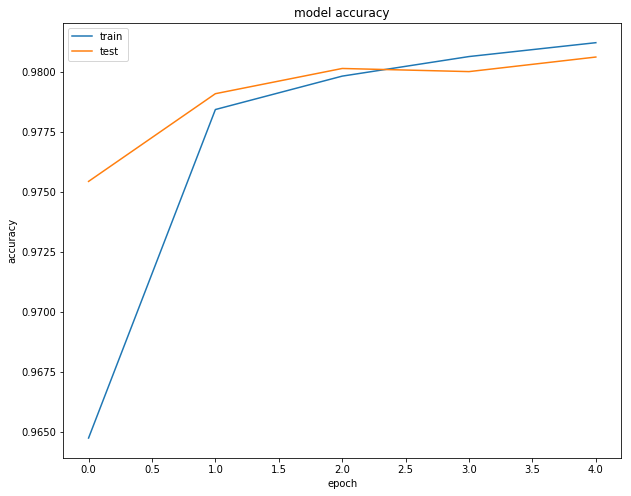

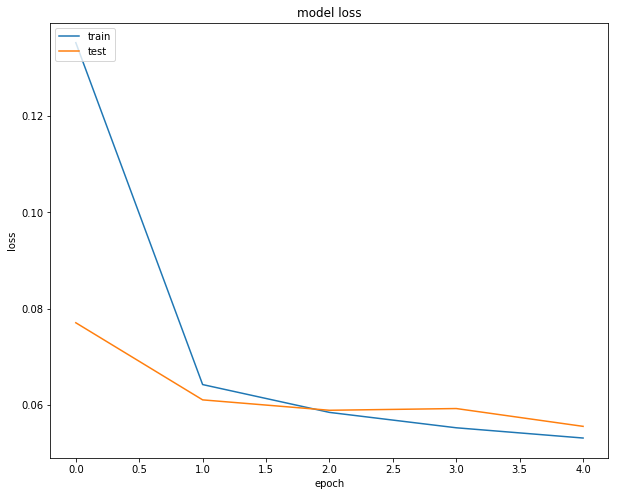

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()